In this notebook, we are going to implement a graph coloring algorithm based on a MIS solver. 

You may need to install the pandas library if it is not already installed.

In [3]:
!pip install pandas

/usr/lib64/python3.12/pty.py:95: DeprecationWarning: This process (pid=13185) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
# imports
from mis import MISSolver, MISInstance, SolverConfig
from mis.shared.types import MISSolution, MethodType
from mis.pipeline.backends import QutipBackend
import networkx as nx
from collections import defaultdict
import pandas as pd
from math import atan2, cos, radians, sin, sqrt

## Importing our dataset

The practical dataset of interest is the placement of 5G antennas in Paris that can be found in the `antenna_Paris.csv` file. A set of antennas are distributed over the city with a specific coverage range. Therefore, some antennas will be in range of each other.

In [12]:
df = pd.read_csv('./antenna_Paris.csv', sep=';')
df

,id,adm_lb_nom,sup_id,emr_lb_systeme,emr_dt,sta_nm_dpt,code_insee,generation,date_maj,sta_nm_anfr,...,tpo_id,adr_lb_lieu,adr_lb_add1,adr_lb_add2,adr_lb_add3,adr_nm_cp,com_cd_insee,coordonnees,coord,statut
0,155450,ORANGE,103853,5G NR 3500,NaN,75,75112,5G,2023-01-18,752290188,...,28,NaN,18 Bd de Picpus,NaN,NaN,75012,75112,"48.840555555556, 2.401111111111",48°50'26''N 2°24'4''E,Projet approuvé
1,155460,ORANGE,103929,5G NR 3500,NaN,75,75112,5G,2023-01-18,752290228,...,28,NaN,278 r du faubourg st antoine,NaN,NaN,75012,75112,"48.848333333333, 2.393888888889",48°50'54''N 2°23'38''E,Projet approuvé
2,162536,ORANGE,57935,5G NR 3500,NaN,75,75119,5G,2023-01-18,752290185,...,22,NaN,23 r michel hidalgo,NaN,NaN,75019,75119,"48.881388888889, 2.390555555556",48°52'53''N 2°23'26''E,Projet approuvé
3,171094,ORANGE,439752,5G NR 3500,NaN,75,75112,5G,2023-01-18,752291426,...,9,NaN,9 r de reuilly,NaN,NaN,75012,75112,"48.849166666667, 2.385555555556",48°50'57''N 2°23'8''E,Projet approuvé
4,172014,ORANGE,440178,5G NR 3500,NaN,75,75111,5G,2023-01-18,752291425,...,2,NaN,17 imp truillot,NaN,NaN,75011,75111,"48.86, 2.373888888889",48°51'36''N 2°22'26''E,Projet approuvé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,333108,ORANGE,2728258,5G NR 3500,NaN,75,75118,5G,2023-01-18,752292745,...,9,NaN,14B Rue Joseph de Maistre,NaN,NaN,75018,75118,"48.886666666667, 2.333055555556",48°53'12''N 2°19'59''E,Projet approuvé
122,333114,ORANGE,2728260,5G NR 3500,NaN,75,75112,5G,2023-01-18,752292746,...,15,NaN,227 Rue de Bercy,NaN,NaN,75012,75112,"48.846111111111, 2.369444444444",48°50'46''N 2°22'10''E,Projet approuvé
123,334263,ORANGE,2719655,5G NR 3500,NaN,75,75109,5G,2023-01-18,752292744,...,29,NaN,12 bd Haussmann,Hôtel Millennium,NaN,75009,75109,"48.8725, 2.337777777778",48°52'21''N 2°20'16''E,Projet approuvé
124,334331,ORANGE,2742547,5G NR 3500,NaN,75,75117,5G,2023-01-18,752290092,...,28,NaN,17 RUE HENRI TUROT,NaN,NaN,75017,75117,"48.876944444444, 2.373611111111",48°52'37''N 2°22'25''E,Projet approuvé


Since we are only interested in the distances between antennas, we will keep only an array of the coordinates

In [66]:
dataset = [(float(c.split(',')[0]),float(c.split(',')[1])) for c in df['coordonnees']]
dataset

[(48.840555555556, 2.401111111111),
 (48.848333333333, 2.393888888889),
 (48.881388888889, 2.390555555556),
 (48.849166666667, 2.385555555556),
 (48.86, 2.373888888889),
 (48.845, 2.384722222222),
 (48.869722222222, 2.306944444444),
 (48.892777777778, 2.323055555556),
 (48.879444444444, 2.343055555556),
 (48.876944444444, 2.366666666667),
 (48.861666666667, 2.320555555556),
 (48.862222222222, 2.364444444444),
 (48.891944444444, 2.350833333333),
 (48.860555555556, 2.352222222222),
 (48.849444444444, 2.3875),
 (48.864166666667, 2.332777777778),
 (48.845555555556, 2.324166666667),
 (48.838055555556, 2.308333333333),
 (48.864444444444, 2.373611111111),
 (48.828611111111, 2.326111111111),
 (48.841666666667, 2.301666666667),
 (48.841666666667, 2.295),
 (48.848055555556, 2.286111111111),
 (48.841666666667, 2.2875),
 (48.853611111111, 2.288888888889),
 (48.851944444444, 2.298055555556),
 (48.835, 2.307222222222),
 (48.829166666667, 2.373611111111),
 (48.830833333333, 2.366111111111),
 (48.8344

Let's define a function to find the distance in kilometers between two antennas.

In [19]:
def distance(a_1 : tuple[float, float],a_2 : tuple[float, float]) -> float:
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = radians(a_1[0]), radians(a_1[1])
    lat2, lon2 = radians(a_2[0]), radians(a_2[1])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance_km = R * c
    return distance_km

In [67]:
# testing on the first two antennas
distance(dataset[0], dataset[1])

1.0135507114534137

## Representing our problem instance
- We will represent the problem by a graph, such that each node represents an antenna, with an edge between two if they are in the range of each other. We consider that all the antennas have a constant range R, which we will set to $1.2km$.

In [101]:
class GraphRepresentation:
    def __init__(self, antennas: set[int], dataset: list[tuple[float, float]], range: float):
        self.graph = nx.Graph()
        self.antennas = antennas
        self.dataset = dataset
        self.range = range
        self.build_graph()

    def build_graph(self):
        for i in self.antennas:
            self.graph.add_node(i)
            
        for i in self.antennas:
            for j in self.antennas:
                if i < j and distance(dataset[i], dataset[j]) <= self.range:
                    self.graph.add_edge(i, j)
                    
    def visualize(self):
        pos = {i: (self.dataset[i][1], self.dataset[i][0]) for i in self.antennas}
        nx.draw(self.graph, pos, with_labels=True, node_size=600, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')
        # fix that singletons don't appear
        
        return pos


    def get_instance(self) -> MISSolution:
        return MISInstance(self.graph)

Let's try to find a MIS on the graph representing the 14 first antennas :

{0: (2.401111111111, 48.840555555556),
 1: (2.393888888889, 48.848333333333),
 2: (2.390555555556, 48.881388888889),
 3: (2.385555555556, 48.849166666667),
 4: (2.373888888889, 48.86),
 5: (2.384722222222, 48.845),
 6: (2.306944444444, 48.869722222222),
 7: (2.323055555556, 48.892777777778),
 8: (2.343055555556, 48.879444444444),
 9: (2.366666666667, 48.876944444444),
 10: (2.320555555556, 48.861666666667),
 11: (2.364444444444, 48.862222222222),
 12: (2.350833333333, 48.891944444444),
 13: (2.352222222222, 48.860555555556)}

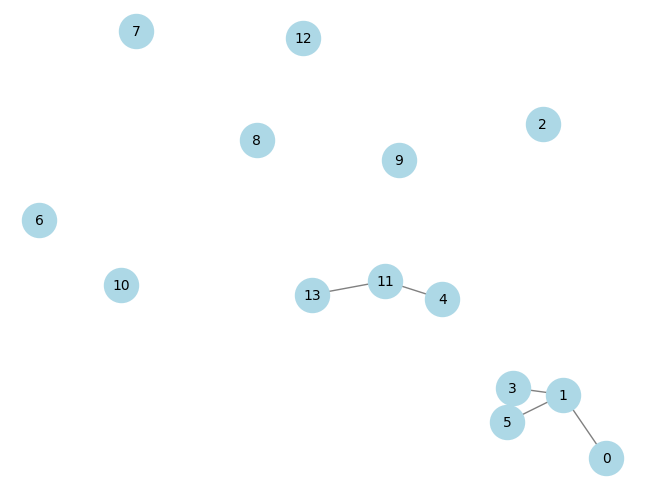

In [102]:
# Create the MIS instance
graph = GraphRepresentation(range(0,14), dataset, 1.2)
graph.visualize()

In [103]:
# Run the solver
config = SolverConfig()
solver = MISSolver(graph.get_instance(), config)
solutions = solver.solve().result()

solutions

[MISSolution(original=<networkx.classes.graph.Graph object at 0x7f7750ea8d10>, nodes=[0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13], frequency=1.0)]

## Solving the RMP Problem
We will use the greedy heuristic algorithm described in [Appendix A](https://arxiv.org/pdf/2301.02637) to find a coloring of the graph using MIS output at each iteration.

Notice that we test our algorithm on the first 100 antennas of the dataset.

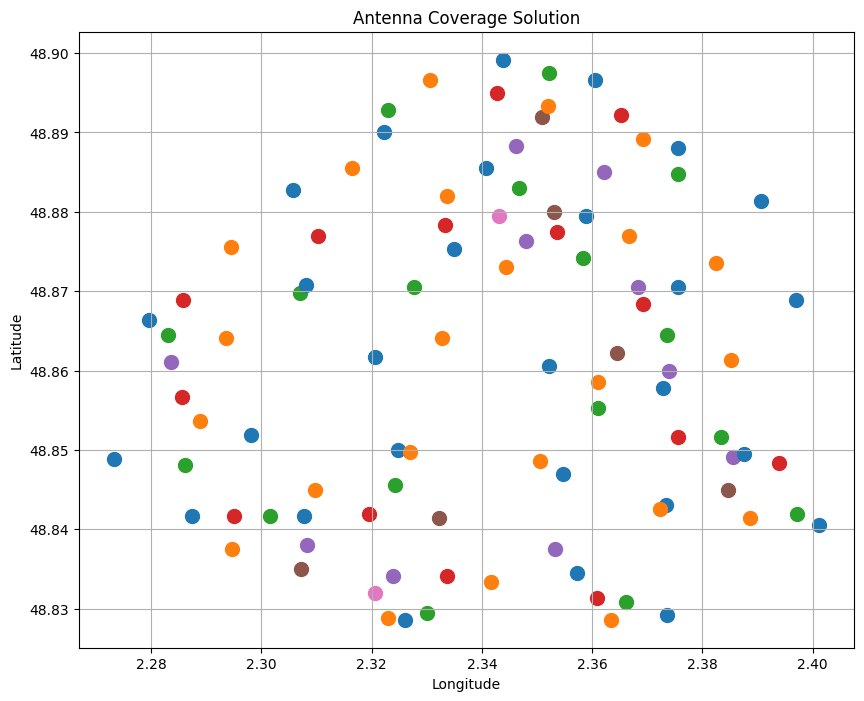

[0, 3, 0, 4, 4, 5, 2, 2, 6, 1, 0, 5, 5, 0, 0, 1, 2, 4, 2, 0, 2, 3, 2, 0, 1, 0, 5, 0, 2, 0, 2, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 4, 1, 3, 3, 3, 1, 1, 1, 2, 4, 2, 4, 2, 2, 0, 1, 2, 1, 4, 1, 1, 2, 5, 1, 4, 1, 3, 3, 0, 0, 2, 1, 0, 2, 3, 4, 3, 3, 4, 1, 3, 0, 0, 5, 0, 3, 1, 6, 0, 1, 0, 1, 3, 0, 0]
Number of colors used: 7


In [118]:
RANGE = 1.2
# RMP Implementation
antennas = set([x for x in range(0, 100)])
colors = [-1]*len(antennas)

color = 0
while len(antennas) > 0:
    graph = GraphRepresentation(antennas, dataset, RANGE)
    solver = MISSolver(graph.get_instance(), SolverConfig())
    solutions = solver.solve().result()
    for antenna in solutions[0].nodes:
        colors[antenna] = color
    antennas = antennas - set(solutions[0].nodes)
    color += 1

# Visualization of the final solution
import matplotlib.pyplot as plt
def visualize_solution(dataset, colors):
    plt.figure(figsize=(10, 8))
    for i, (lat, lon) in enumerate(dataset):
        plt.scatter(lon, lat, c=f'C{colors[i]}', label=f'Antenna {i}' if colors[i] == 0 else "", s=100)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Antenna Coverage Solution')
    plt.grid()
    plt.show()
    
visualize_solution(dataset[0:100], colors)
print(colors)
print(f"Number of colors used: {color}")